In [1]:
from itertools import product
from sklearn.gaussian_process import GaussianProcess

class BayesianOptimizer:
    x_list = None
    y_list = None
    yielding_index = None
    k_band = 5
    verbose = False

    def __init__(self, params):
        self.params = params
        self.keys = []
        self.values = []
        for k, v in sorted(self.params.items()):
            self.keys.append(k)
            self.values.append(v)

    @property
    def n_pattern(self):
        return len(list(product(*self.values)))

    def output(self, *args, **kwargs):
        if self.verbose:
            print(*args, **kwargs)
    
    def supply_next_param(self, max_iter=None):
        self.x_list = []
        self.y_list = []
        all_parameters = list(product(*self.values))  # [(0.01, [0, 0], 0, [10, 10]), (0.01, [0, 0], 0, [15, 15]), ...
        index_space = [list(range(len(v))) for v in self.values]  # [[0], [0, 1, 2], [0], [0, 1, 2]]
        all_index_list = list(product(*index_space))  # [(0, 0, 0, 0), (0, 0, 0, 1), ...

        # examine 2 random points initially
        idx = list(range(len(all_index_list)))
        np.random.shuffle(idx)
        searched_index_list = []
        for index in idx[:2]:
            param = self.to_param(all_parameters[index])
            self.yielding_index = all_index_list[index]
            searched_index_list.append(index)
            yield param

        # Bayesian Optimization
        max_iter = int(min(max_iter or max(np.sqrt(self.n_pattern)*4, 20), self.n_pattern))  # 最大探索回数を適当に計算。
        for iteration in range(max_iter):
            k = 1 + np.exp(-iteration / max_iter * 3) * self.k_band  # kの値を徐々に減らして 探索重視 → 活用重視 にしてみる
            gp = self.create_gp_and_fit(np.array(self.x_list), np.array(self.y_list))

            mean_array, mse_array = gp.predict(all_index_list, eval_MSE=True)
            next_index, acq_array = self.acquisition(mean_array, mse_array, k, excludes=searched_index_list)

            self.output("--- Most Expected Predictions")
            for acq, ps in sorted(zip(acq_array, all_parameters), reverse=True)[:3]:
                self.output("%.2f: %s" % (acq, list(zip(self.keys, ps))))
            self.output("--- Past Best Results")
            for acq, vs, ps in self.best_results(3):
                self.output("%.2f: %s" % (acq, list(zip(self.keys, vs))))

            if next_index in searched_index_list:
                break
            searched_index_list.append(next_index)
            self.yielding_index = all_index_list[next_index]
            yield self.to_param(all_parameters[next_index])

    @staticmethod
    def create_gp_and_fit(x, y, max_try=100):
        # この辺怪しい
        theta0 = 0.1
        for i in range(max_try+1):
            try:
                # gp = GaussianProcess(theta0=0.1, thetaL=.001, thetaU=theta_u)
                gp = GaussianProcess(theta0=theta0)
                gp.fit(x, y)
                return gp
            except Exception as e:
                theta0 *= 10
                if i == max_try:
                    print(theta0)
                    raise e
            
    def to_param(self, row):
        return dict(zip(self.keys, row))

    def report(self, score):
        self.x_list.append(self.yielding_index)
        self.y_list.append(score)

    def best_results(self, n=5):
        index_list = []
        param_list = []
        for xs in self.x_list:
            values = [self.values[i][x] for i, x in enumerate(xs)]
            index_list.append(values)
            param_list.append(self.to_param(values))
        return sorted(zip(self.y_list, index_list, param_list), reverse=True)[:n]

    @staticmethod
    def acquisition(mean_array, mse_array, k, excludes=None):
        excludes = excludes or []
        values = mean_array + np.sqrt(mse_array) * k
        for_argmax = np.copy(values)
        for ex in excludes:
            for_argmax[ex] = -np.Inf
        return np.argmax(for_argmax), values


In [2]:
# for testing on jupyter notebook
import os

PRJ_ROOT = '/home/jovyan/work'
os.chdir("%s/notebooks/sandbox/" % PRJ_ROOT)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

sns.set_style('whitegrid')
sns.set(font=['IPAPGothic'])

%reload_ext autoreload
%autoreload 2

In [3]:
z = np.linspace(0, 3.14)
z1 = np.expand_dims(z, axis=0)
z2 = np.expand_dims(z, axis=1)
value_space = np.sin((z1-1.5)*4) * np.cos(z2-0.2) + np.sin(z1+0.1) * np.cos((z2-1.5)*5) * 0.8
value_space *= 70
value_space += np.random.normal(size=value_space.shape)*10

def unknown_function(ps):
    return value_space[ps[0], ps[1]]

f(row=3, col=29) = 133.318


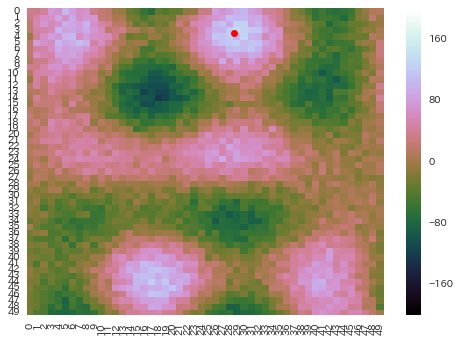

In [4]:
space_size = value_space.shape
sns.heatmap(value_space, cmap='cubehelix', vmin=np.min(value_space)*1.5, vmax=np.max(value_space)*1.5)
max_i, max_v = np.argmax(value_space), np.max(value_space)
col, row = max_i % space_size[0], max_i // space_size[0]
sns.plt.plot(col, space_size[0] - row-1, 'ro')
print("f(row=%d, col=%d) = %.3f" % (row, col, max_v))

In [6]:
def plot_heatmap(value_space, checked_points):
    sns.heatmap(value_space, cmap='cubehelix', vmin=np.min(value_space)*1.5, vmax=np.max(value_space)*1.5)
    
    cp = np.array(checked_points)
    rows = value_space.shape[0] - cp[:, 0] - 1
    cols = cp[:, 1]
    plt.plot(cols, rows, 'ro', markersize=5)
    plt.plot(cols[-1], rows[-1], 'o', markersize=10)

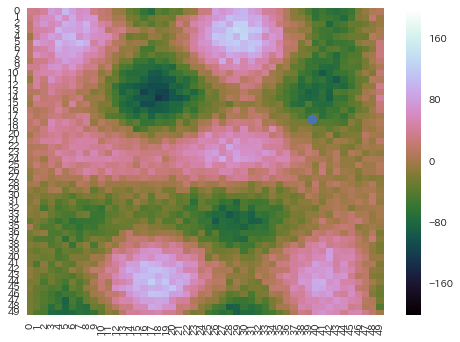

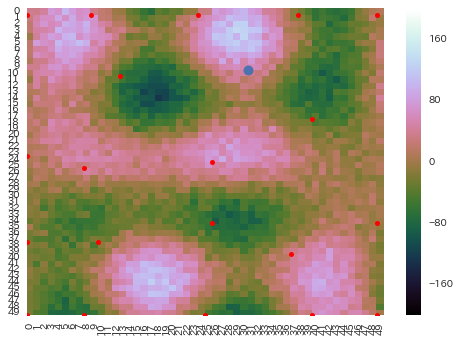

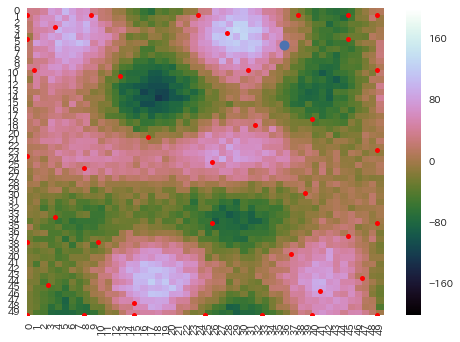

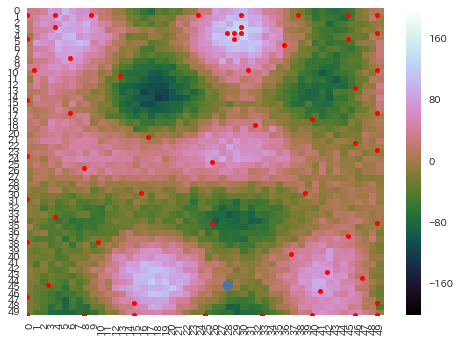

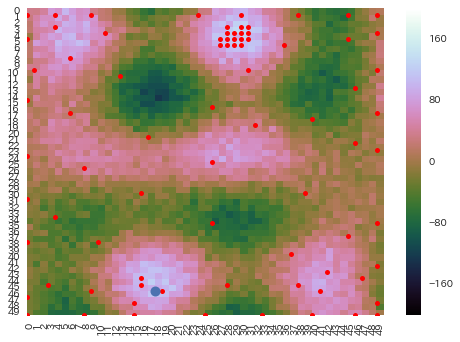

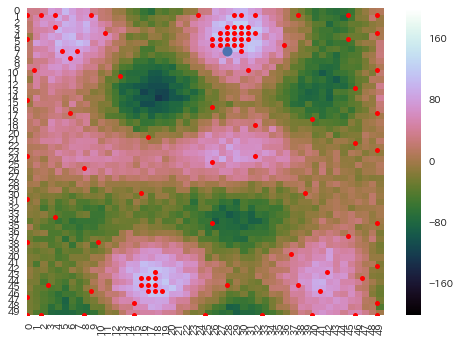

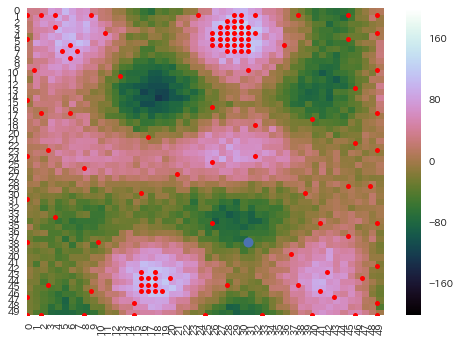

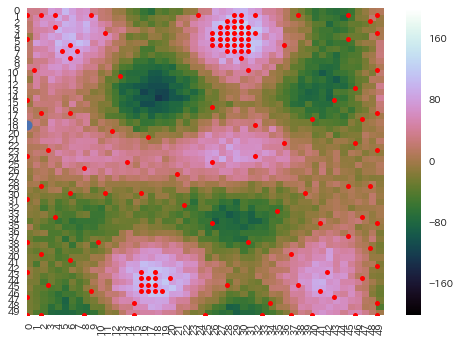

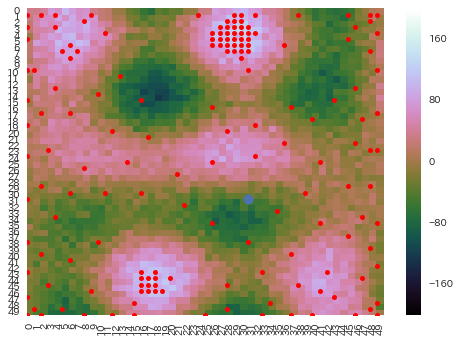

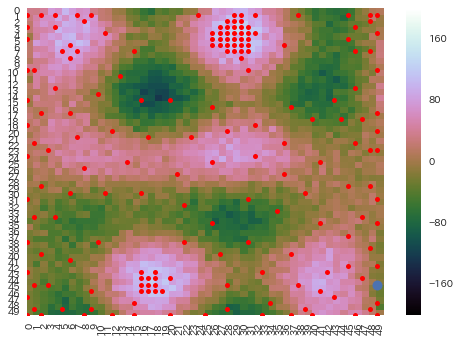

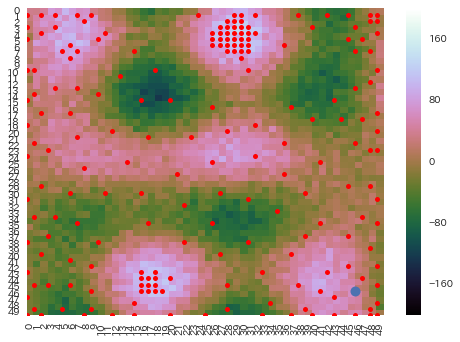

In [7]:
params = {
    "col": list(range(50)),
    "row": list(range(50)),
}

bo = BayesianOptimizer(params)
checked_points = []

for i, param in enumerate(bo.supply_next_param()):  # param is dict
    x = [param['row'], param['col']]
    y = unknown_function(x)
    bo.report(y)
    
    checked_points.append(x)
    
    if i % 20 == 0:
        plot_heatmap(value_space, checked_points)
        sns.plt.show()

In [8]:
bo.best_results()

[(133.3180371984318, [29, 3], {'col': 29, 'row': 3}),
 (130.50108806139116, [30, 4], {'col': 30, 'row': 4}),
 (127.56417273171563, [30, 3], {'col': 30, 'row': 3}),
 (126.535039385248, [29, 2], {'col': 29, 'row': 2}),
 (126.12708338971005, [30, 2], {'col': 30, 'row': 2})]